In [42]:
import os
import time
import glob
import re
from functools import reduce
from klepto.archives import dir_archive
import numpy as np
import uproot
import uproot_methods
import awkward
import pandas as pd

import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
from coffea import hist

%matplotlib inline
import matplotlib.pyplot as plt

In [66]:
#define processor

class WHhadProcessor(processor.ProcessorABC):
    def __init__(self):
        
        #define bins
        dataset_axis         = hist.Cat("dataset", "Primary dataset")
        pt_axis              = hist.Bin("pt", r"$p_{T}$ (GeV)", 600, 0, 2000)
        mass_axis            = hist.Bin("mass", r"$mass$ (GeV)", 600, 0, 2000)
        eta_axis             = hist.Bin("eta", r"$\eta$", 60, -5.5, 5.5)
        multiplicity_axis    = hist.Bin("multiplicity", r"N", 20, -0.5, 19.5)
        
        #define dictionary for plots
        self._accumulator = processor.dict_accumulator({
            "MET_pt":           hist.Hist("Counts", dataset_axis, pt_axis),
            "Jet_pt" :          hist.Hist("Counts", dataset_axis, pt_axis),
            "Jet_eta" :         hist.Hist("Counts", dataset_axis, eta_axis),
            "Jet_mass":         hist.Hist("Counts", dataset_axis, mass_axis),
            "N_B" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_Jet" :           hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_FatJet" :        hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "FatJet_pt" :       hist.Hist("Counts", dataset_axis, pt_axis),
            "MT_FatJet":        hist.Hist("Counts", dataset_axis, mass_axis),
            "MT_W_FatJet":      hist.Hist("Counts", dataset_axis, mass_axis),
            "MT_H_FatJet":      hist.Hist("Counts", dataset_axis, mass_axis),
            "N_fatjet_W" :      hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_fatjet_H" :      hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "HT":               hist.Hist("Counts", dataset_axis, pt_axis),
            "Mass_Hbb":         hist.Hist("Counts", dataset_axis, mass_axis),
            "Mass_Hbb_sd":      hist.Hist("Counts", dataset_axis, mass_axis),
            "Mass_Wqq":         hist.Hist("Counts", dataset_axis, mass_axis),
            "Mass_Wqq_sd":      hist.Hist("Counts", dataset_axis, mass_axis)
            })

    
    @property
    def accumulator(self):
        return self._accumulator

    
    def process(self, df):
        
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        
        
        #PRESELECTION
        met_ps = (df['MET_pt']>250)
        njet_ps = (df['nJet'] >2)
        bjet_ps = (df['nGoodBTag'] > 1)
        tauveto_ps = (df['nVetoTau'] == 0)
        isotrackveto_ps = (df['nVetoIsoTrack'] == 0)
        
        presel = met_ps & njet_ps & bjet_ps & tauveto_ps & isotrackveto_ps
        
        #DEFINE VARIABLES 
        
            #jets
        jets = awkward.JaggedArray.zip(pt=df['Jet_pt'], eta=df['Jet_eta'], phi=df['Jet_phi'], btag=df['Jet_btagDeepB'], jetid=df['Jet_jetId'], mass=df['Jet_mass'], n=df['nJet'])
        goodjets = jets[(jets['pt']>30) & (abs(jets['eta'])<2.4) & (jets['jetid']>0) ]
        bjets = jets[(jets['pt']>30) & (abs(jets['eta'])<2.4) & (jets['jetid']>0) & (jets['btag']>0.4184) ]
        fatjets = awkward.JaggedArray.zip(pt=df['FatJet_pt'], eta=df['FatJet_eta'], phi=df['FatJet_phi'], mass=df['FatJet_mass'], softdrop=df["FatJet_msoftdrop"], btag=df['FatJet_btagDeepB'], n=df['nFatJet'],fromH = df['FatJet_deepTagMD_HbbvsQCD'], fromW = df['FatJet_deepTagMD_WvsQCD'], fatjetid=df['FatJet_jetId'])
        goodfatjets = fatjets[(fatjets['pt'] > 200) & (fatjets['fatjetid']>0)]
        fatjet_fromW = fatjets[(fatjets['n']>1) & (fatjets['pt'] > 200) & (fatjets['fatjetid']>0) & (fatjets['fromW'] > 0.9)]
        fatjet_fromH = fatjets[(fatjets['n']>1) & (fatjets['pt'] > 200) & (fatjets['fatjetid']>0) & (fatjets['fromH'] > 0.8365)]

        
            #mt
        deltaphi_fatjet_met = fatjets['phi'] - df["MET_phi"]
        mt_fatjet_met = np.sqrt(2*fatjets['pt']*df["MET_pt"]*(1-np.cos(deltaphi_fatjet_met)))
        
        
        #DEFINE SELECTION
        fatjet_W_sel = ((fatjets['n']>1) & (fatjets['pt'] > 200) & (fatjets['fatjetid']>0) & (fatjets['fromW'] > 0.9))
        fatjet_H_sel = ((fatjets['n']>1) & (fatjets['pt'] > 200) & (fatjets['fatjetid']>0) & (fatjets['fromH'] > 0.8365))

        
        #FILL OUTPUTS
        output['MET_pt'].fill(dataset=dataset, pt=df["MET_pt"][presel].flatten(),
                              weight=df['weight'][presel])
        
        output['Jet_pt'].fill(dataset=dataset, pt=df["Jet_pt"][presel].max().flatten(),weight=df['weight'][presel]) # maximum jet pt
        output['Jet_eta'].fill(dataset=dataset, eta=df["Jet_eta"][presel].flatten())
        output['Jet_mass'].fill(dataset=dataset, mass=df["Jet_mass"][presel].flatten())
        output['N_Jet'].fill(dataset=dataset, multiplicity=goodjets[presel].counts)        
        output['N_B'].fill(dataset=dataset, multiplicity=bjets[presel].counts)
        output['N_FatJet'].fill(dataset=dataset, multiplicity=goodfatjets[presel].counts)
        output['FatJet_pt'].fill(dataset=dataset, pt=df["FatJet_pt"][presel].max().flatten(),weight=df['weight'][presel]) # maximum jet pt
        
        output['MT_FatJet'].fill(dataset=dataset, mass=mt_fatjet_met[presel].flatten())
               
        output['N_fatjet_W'].fill(dataset=dataset, multiplicity=fatjet_fromW[presel].counts)
        output['N_fatjet_H'].fill(dataset=dataset, multiplicity=fatjet_fromH[presel].counts)
        
        output['MT_W_FatJet'].fill(dataset=dataset, mass=mt_fatjet_met[fatjet_W_sel][presel].flatten())
        output['MT_H_FatJet'].fill(dataset=dataset, mass=mt_fatjet_met[fatjet_H_sel][presel].flatten())

        output['HT'].fill(dataset=dataset,pt=goodjets['pt'][presel].sum().flatten())
         
        output['Mass_Hbb'].fill(dataset=dataset, mass=fatjets['mass'][fatjet_H_sel][presel].flatten())
        output['Mass_Hbb_sd'].fill(dataset=dataset, mass=fatjets['softdrop'][fatjet_H_sel][presel].flatten())
        output['Mass_Wqq'].fill(dataset=dataset, mass=fatjets['mass'][fatjet_W_sel][presel].flatten())
        output['Mass_Wqq_sd'].fill(dataset=dataset, mass=fatjets['softdrop'][fatjet_W_sel][presel].flatten())
        
        return output

    
    def postprocess(self, accumulator):
        return accumulator
        

In [67]:
histograms = ["MET_pt", "Jet_pt", "Jet_eta","Jet_mass", "N_B", "N_Jet", "N_FatJet", 
              "FatJet_pt", "MT_FatJet", "N_fatjet_W", "N_fatjet_H", "MT_W_FatJet", 
              "MT_H_FatJet", "HT", "Mass_Hbb", "Mass_Hbb_sd", "Mass_Wqq", "Mass_Wqq_sd"]

fileset = {'mC750_mL1': ['/Users/mirandabryson/coffea/WHfiles/WH_had_750_1__nanoAOD_1.root'],
          #'TThad': ['/Users/mirandabryson/coffea/data/AF7356E5-7B61-E14A-A782-B4D7F1B1C4EA.root']
          }

output = processor.run_uproot_job(fileset,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )
     
outdir = "/Users/mirandabryson/coffea/plots"


MET_pt
Jet_pt
Jet_eta


/Users/mirandabryson/anaconda/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/Users/mirandabryson/anaconda/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/Users/mirandabryson/anaconda/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


Jet_mass
N_B
N_Jet


/Users/mirandabryson/anaconda/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/Users/mirandabryson/anaconda/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/Users/mirandabryson/anaconda/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


N_FatJet
FatJet_pt
MT_FatJet


/Users/mirandabryson/anaconda/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/Users/mirandabryson/anaconda/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/Users/mirandabryson/anaconda/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


N_fatjet_W
N_fatjet_H
MT_W_FatJet


/Users/mirandabryson/anaconda/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/Users/mirandabryson/anaconda/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/Users/mirandabryson/anaconda/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


MT_H_FatJet
HT
Mass_Hbb


/Users/mirandabryson/anaconda/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/Users/mirandabryson/anaconda/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/Users/mirandabryson/anaconda/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


Mass_Hbb_sd
Mass_Wqq
Mass_Wqq_sd


/Users/mirandabryson/anaconda/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/Users/mirandabryson/anaconda/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/Users/mirandabryson/anaconda/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


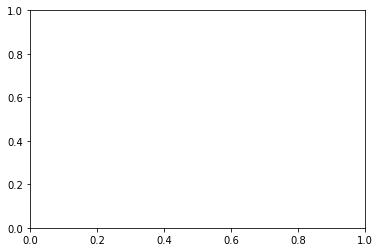

In [71]:
for name in histograms:
        print (name)
        histogram = output[name]
        #rebinning
        if name == 'MET_pt':
            new_met_bins = hist.Bin('pt', r'$E_T^{miss} \ (GeV)$', 20, 0, 1400)
            histogram = histogram.rebin('pt', new_met_bins)
        if name == 'Jet_pt':
            new_jetpt_bins = hist.Bin('pt', r'Jet $p_T (GeV)$', 50, 0 , 1000)
            histogram = histogram.rebin('pt', new_jetpt_bins)
        if name == 'FatJet_pt':
            new_fatjetpt_bins = hist.Bin('pt', r'FatJet $p_T (GeV)$', 50, 0 , 1000)
            histogram = histogram.rebin('pt', new_fatjetpt_bins)
        if name == 'Jet_mass':
            new_jetmass_bins = hist.Bin('mass', r'Jet $Mass (GeV)$', 20, 0, 200)
            histogram = histogram.rebin('mass', new_jetmass_bins)
        if name == 'N_B':
            new_nb_bins = hist.Bin('multiplicity', r'$N_{Bjets}$', 6, -0.5 , 5.5)
            histogram = histogram.rebin('multiplicity', new_nb_bins)
        if name == 'N_Jet':
            new_njet_bins = hist.Bin('multiplicity', r'$N_{jets}$', 11, -0.5 , 10.5)
            histogram = histogram.rebin('multiplicity', new_njet_bins)
        if name == 'N_FatJet':
            new_nfatjet_bins = hist.Bin('multiplicity', r'$N_{fatjets}$', 6, -0.5 , 5.5)
            histogram = histogram.rebin('multiplicity', new_nfatjet_bins)
        if name == 'N_fatjet_H':
            new_nfatjeth_bins = hist.Bin('multiplicity', r'$N_{fatjets}$', 6, -0.5 , 5.5)
            histogram = histogram.rebin('multiplicity', new_nfatjeth_bins)
        if name == 'N_fatjet_W':
            new_nfatjetw_bins = hist.Bin('multiplicity', r'$N_{fatjets}$', 6, -0.5 , 5.5)
            histogram = histogram.rebin('multiplicity', new_nfatjetw_bins)
        if name == 'MT_FatJet':
            new_mtfatjet_bins = hist.Bin('mass', r'$M_T$', 40, 0, 2000)
            histogram = histogram.rebin('mass', new_mtfatjet_bins)
        if name == 'MT_W_FatJet':
            new_mtw_bins = hist.Bin('mass', r'$M_T (W \rightarrow qq , MET) $ (GeV)', 20, 0, 2000)
            histogram = histogram.rebin('mass', new_mtw_bins)
        if name == 'MT_H_FatJet':
            new_mth_bins = hist.Bin('mass', r'$M_T(H \rightarrow bb , MET) $(GeV)', 20, 0, 2000)
            histogram = histogram.rebin('mass', new_mth_bins)
        if name == 'HT':
            new_ht_bins = hist.Bin('pt', r'H_T(GeV)$', 20, 200, 2000)
            histogram = histogram.rebin('pt', new_ht_bins)
        if name == 'Mass_Hbb':
            new_masshbb_bins = hist.Bin('mass', r'$M_{H \rightarrow bb}$ (GeV)', 20, 0, 200)
            histogram = histogram.rebin('mass', new_masshbb_bins)
        if name == 'Mass_Hbb_sd':
            new_masshbbsd_bins = hist.Bin('mass', r'$M_{H \rightarrow bb} (softdrop) (GeV)$', 20, 0, 200)
            histogram = histogram.rebin('mass', new_masshbbsd_bins)
        if name == 'Mass_Wqq':
            new_masswqq_bins = hist.Bin('mass', r'$M_{W \rightarrow qq}$ (GeV)', 20, 0, 200)
            histogram = histogram.rebin('mass', new_masswqq_bins)
        if name == 'Mass_Wqq_sd':
            new_masswqqsd_bins = hist.Bin('mass', r'$M_{W \rightarrow qq} (softdrop) (GeV)$', 20, 0, 200)
            histogram = histogram.rebin('mass', new_masswqqsd_bins)
            
        ax = hist.plot1d(histogram,overlay="dataset", density=False, stack=False, 
                        fill_opts={'alpha': 0.6, 'edgecolor': (0,0,0,1)}
                        ) # make density plots because we don't care about x-sec differences
        ax.set_yscale('linear') # can be log
        #ax.set_ylim(0,0.1)
        ax.figure.savefig(os.path.join(outdir, "{}.pdf".format(name)))
        ax.clear()

